In [1]:
import os
import analysis
from analysis import std_phase, ipr, pca_entropy, renyi_entropy
import matplotlib.pyplot as plt

In [2]:
hypotheses = {
    "std_phase" : std_phase,
    "IPR" : ipr,
    "SPCA" : pca_entropy,
    "Renyi_2" : renyi_entropy,
}

h5_files = [os.path.join("../data/data_rand", f) for f in os.listdir('../data/data_rand') if f.endswith('.h5')]

df = analysis.load_outputs_to_dataframe(h5_files)
df = analysis.attach_hypotheses_fields(df, hypotheses)
print(len(df))

230


In [3]:
def filter_dataframe_by_range(df, field, lower_bound, upper_bound):
    """
    Filters the DataFrame to include only rows where the specified field's values
    are within the given range (exclusive).

    Parameters:
        df (pd.DataFrame): The input DataFrame.
        field (str): The column name to filter by.
        lower_bound (float): The lower bound of the range (exclusive).
        upper_bound (float): The upper bound of the range (exclusive).

    Returns:
        pd.DataFrame: A filtered DataFrame.
    """
    return df[(df[field] > lower_bound) & (df[field] < upper_bound)]

/tmp/ipykernel_2677092/4114662691.py:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


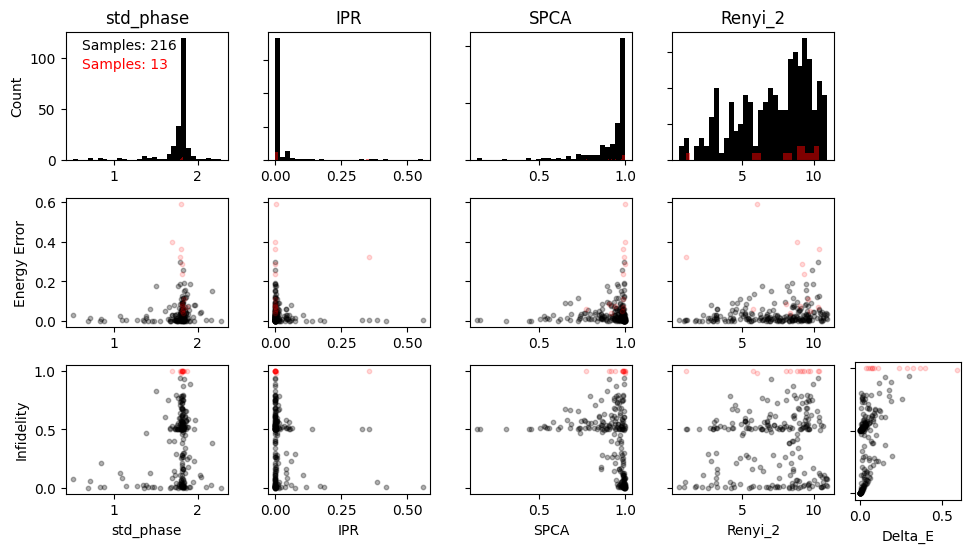

In [4]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

def plotCorrelations(df_eval, hypotheses, plt_fig=None, text_offset=None, color="black", alphamod=1., ylog=False):
    scatter_size = 10
    N = len(hypotheses)
    if plt_fig is None:
        fig = plt.figure(figsize=(0.6*4*N + 1, 0.6*10))  # Extra width for colorbar
        gs = gridspec.GridSpec(3, N+1, width_ratios=[1]*N + [0.08], wspace=0.3, hspace=0.3)
        axes = np.empty((3, N), dtype=object)
        for row in range(3):
            for col in range(N):
                axes[row, col] = fig.add_subplot(gs[row, col])
        bottom_right_ax = fig.add_subplot(gs[-1, -1])
        
    else:
        fig = plt_fig
        all_axes = fig.get_axes()
        axes = np.array(all_axes[:3*N]).reshape(3, N)
        bottom_right_ax = all_axes[-1]
        # The last axis (all_axes[3*N]) is the colorbar or extra axis

    for idx, name in enumerate(hypotheses.keys()):
        if name == "mean_phase":
            data = df_eval[name].abs()
            title = f"|{name}|"
        else:
            data = df_eval[name]
            title = name
        axes[0, idx].hist(data, bins=30, color=color,alpha = alphamod)
        axes[0, idx].set_title(title)
        if idx == 0:
            axes[0, 0].set_ylabel("Count")
        else:
            axes[0, idx].tick_params(axis='y', labelleft=False)

        scatter = axes[1, idx].scatter(data, df_eval["Delta_E"], alpha=0.3*alphamod, s=scatter_size, color=color)
        if idx == 0:
            axes[1, 0].set_ylabel("Energy Error")
        else:
            axes[1, idx].tick_params(axis='y', labelleft=False)
        axes[2, idx].scatter(data, df_eval["infidelity"], alpha=0.3*alphamod, s=scatter_size, color=color)
        axes[2, idx].set_xlabel(title)
        if idx == 0:
            axes[2, 0].set_ylabel("Infidelity")
        else:
            axes[2, idx].tick_params(axis='y', labelleft=False)

        if ylog:
            # apply log scale to y-axis for all three rows for this column
            axes[0, idx].set_yscale('log')
            axes[1, idx].set_yscale('log')
            axes[2, idx].set_yscale('log')

    plt.tight_layout()

    bottom_right_ax.set_position([0.87, 0.1, 0.1, 0.23])
    bottom_right_ax.tick_params(axis='y', labelleft=False)
    bottom_right_ax.scatter(df_eval["Delta_E"], df_eval["infidelity"], alpha=0.3*alphamod, s=scatter_size, color=color)
    bottom_right_ax.set_xlabel("Delta_E")
    if ylog:
        bottom_right_ax.set_yscale('log')
    if text_offset is None:
        text_offset = [0,0]
        if plt_fig is not None:
            text_offset = [0.0,-0.15]
    text_pos = np.array([0.1, 0.95]) + np.array(text_offset)
    axes[0, 0].text(*text_pos, f"Samples: {len(df_eval)}", transform=axes[0, 0].transAxes, fontsize=10, color=color, ha="left", va="top")
    return fig

infidelityrange = (0,0.95)
df_eval = filter_dataframe_by_range(df, 'infidelity', *infidelityrange)
plt_fig = plotCorrelations(df_eval,hypotheses)
infidelityrange = (0.95,1)
df_eval_min = filter_dataframe_by_range(df, 'infidelity', *infidelityrange)

plt_fig = plotCorrelations(df_eval_min,hypotheses,color="red",alphamod=0.5,plt_fig=plt_fig)

In [5]:
df_eval["IPR"]

0      0.040663
1      0.004319
2      0.039184
3      0.000054
4      0.000065
         ...   
224    0.000018
225    0.000485
226    0.000712
228    0.000078
229    0.000976
Name: IPR, Length: 216, dtype: float64

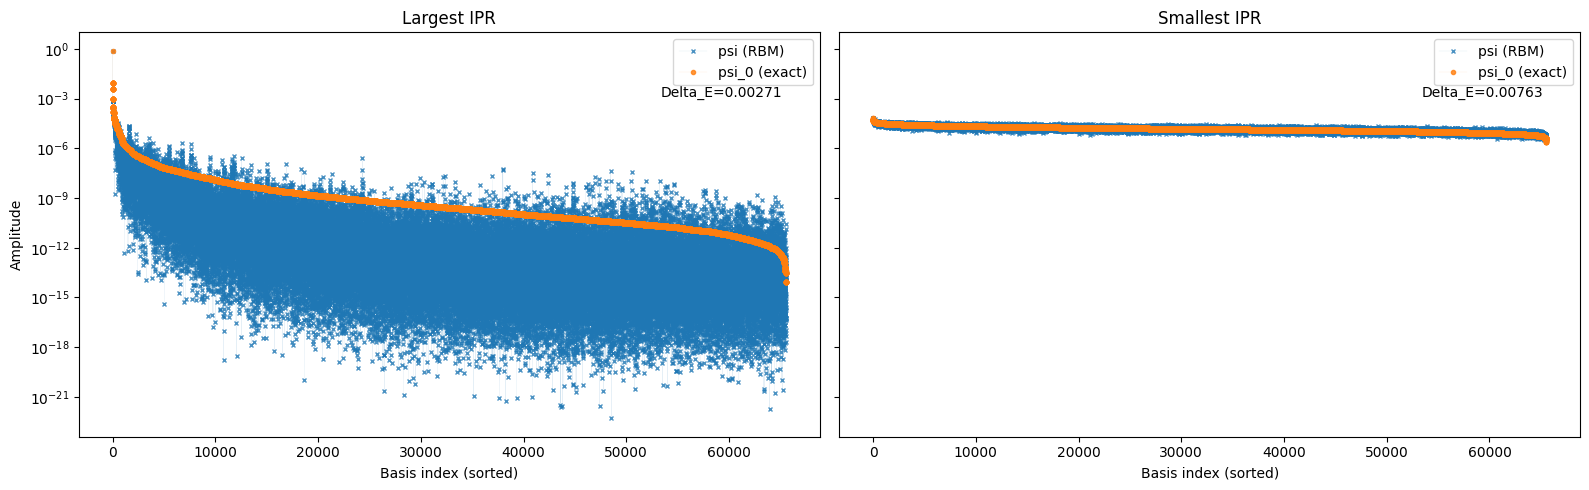

In [6]:
import numpy as np

# Find the index of the row with the largest IPR in df_eval
# Find indices of the row with largest and smallest IPR in df_eval
max_ipr_idx = df_eval["IPR"].idxmax()
min_ipr_idx = df_eval["IPR"].idxmin()

perm = np.argsort(df_eval["IPR"])
# max_ipr_idx = np.int64(32)
# min_ipr_idx = 1

# Extract psi_0 and psi for those rows
psi_0_max_ipr = df_eval.loc[max_ipr_idx, "psi_0"]
psi_max_ipr = df_eval.loc[max_ipr_idx, "psi"]
psi_0_min_ipr = df_eval.loc[min_ipr_idx, "psi_0"]
psi_min_ipr = df_eval.loc[min_ipr_idx, "psi"]

perm_max_ipr = np.argsort(np.abs(psi_0_max_ipr))[::-1]
psi_0_max_ipr = psi_0_max_ipr[perm_max_ipr]
psi_max_ipr = psi_max_ipr[perm_max_ipr]

# For min IPR
perm_min_ipr = np.argsort(np.abs(psi_0_min_ipr))[::-1]
psi_0_min_ipr = psi_0_min_ipr[perm_min_ipr]
psi_min_ipr = psi_min_ipr[perm_min_ipr]

# Convert psi_0 and psi to numpy arrays for plotting
psi_0_max_ipr_arr = np.array(psi_0_max_ipr)
psi_max_ipr_arr = np.array(psi_max_ipr)
psi_0_min_ipr_arr = np.array(psi_0_min_ipr)
psi_min_ipr_arr = np.array(psi_min_ipr)

fig, axs = plt.subplots(1, 2, figsize=(16, 5), sharey=True)

# Plot wavefunctions with largest IPR
axs[0].plot(np.abs(psi_max_ipr_arr)**2, label='psi (RBM)', marker='x', lw=0.05, markersize=3,alpha=0.8)
axs[0].plot(np.abs(psi_0_max_ipr_arr)**2, label='psi_0 (exact)', marker='o', lw=0.05, markersize=3,alpha=0.8)
axs[0].set_xlabel('Basis index (sorted)')
axs[0].set_ylabel('Amplitude')
axs[0].set_yscale('log')
axs[0].set_title('Largest IPR')
axs[0].legend()

# Plot wavefunctions with IPR
axs[1].plot(np.abs(psi_min_ipr_arr)**2, label='psi (RBM)', marker='x', lw=0.05, markersize=3,alpha=0.8)
axs[1].plot(np.abs(psi_0_min_ipr_arr)**2, label='psi_0 (exact)', marker='o', lw=0.05, markersize=3,alpha=0.8)
axs[1].set_xlabel('Basis index (sorted)')
axs[1].set_yscale('log')
axs[1].set_title('Smallest IPR')
axs[1].legend()

axs[0].text(0.95, 0.85, f"Delta_E={df_eval.loc[max_ipr_idx, 'Delta_E']:.3g}", transform=axs[0].transAxes,
            fontsize=10, color="black", ha="right", va="center")
axs[1].text(0.95, 0.85, f"Delta_E={df_eval.loc[min_ipr_idx, 'Delta_E']:.3g}", transform=axs[1].transAxes,
            fontsize=10, color="black", ha="right", va="center")
plt.tight_layout()
plt.show()

Alternative: $$H = \sum_{<i,j>} \sigma_i^z \sigma_j^z - h \sum_i \sigma_i^x + \epsilon H_\text{rand}$$

In [7]:
import importlib
importlib.reload(analysis)

<module 'analysis' from '/net/storage/niggeni/Documents/Projects/DataMiningRBMs/Netket/analysis.py'>

In [8]:
from scipy.stats import pearsonr

def compute_pearson_correlation(series1, series2):
    correlation, p_value = pearsonr(series1, series2)
    return correlation

In [9]:
# h5_files = [os.path.join("data_rand", f) for f in os.listdir('data_rand') if f.endswith('.h5')]
# import analysis


df_rot = analysis.read_folder_to_dataframe("../data/data_random_rotated_rbm")
df_rot = analysis.attach_hypotheses_fields(df_rot, hypotheses)
df_rot["idx"] = df_rot["file"].apply(lambda x: int(os.path.basename(x).split('_')[2]))

In [10]:
import optimization as op
import sys
import rotation
sys.path.append("../python")
import parseCouplings
input_file = "../python/couplings69.csv"
Jijs, hs, bondss = parseCouplings.parseCouplings(input_file)
def rotate_Jij(Jalphabeta, roll, pitch, yaw):
    R = rotation.rotation_matrix_rpy(roll, pitch, yaw)
    return R@Jalphabeta@R.T

def rotate_hi(hi, roll, pitch, yaw):
    R = rotation.rotation_matrix_rpy(roll, pitch, yaw)
    return R@hi
# Select the second column by integer position using .iloc to avoid InvalidIndexError
def add_Jij_h(df, Jijs, hs):
    Jijs_bare = Jijs[df.idx]
    Jijs_unique = [np.unique(J,axis=0) for J in Jijs_bare]
    
    hs_bare = hs[df.idx]
    hs_unique = [np.unique(h,axis=0)[0,:] for h in hs_bare]
    rotations = [rotation.rotation_matrix_rpy(a, b, c) for a, b, c in zip(df["rot_alpha"], df["rot_beta"], df["rot_gamma"])]

    Jij_0 = [R@J[0,:,:]@R.T for J, R in zip(Jijs_unique, rotations)]
    Jij_1 = [R@J[1,:,:]@R.T for J, R in zip(Jijs_unique, rotations)]
    
    hs = [R@h for h, R in zip(hs_unique, rotations)]
    df = df.copy()
    df['Jij_0'] = Jij_0
    df['Jij_1'] = Jij_1
    df['hs'] = hs
    return df
df_rot = add_Jij_h(df_rot, Jijs, hs)

/tmp/ipykernel_2677092/4114662691.py:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


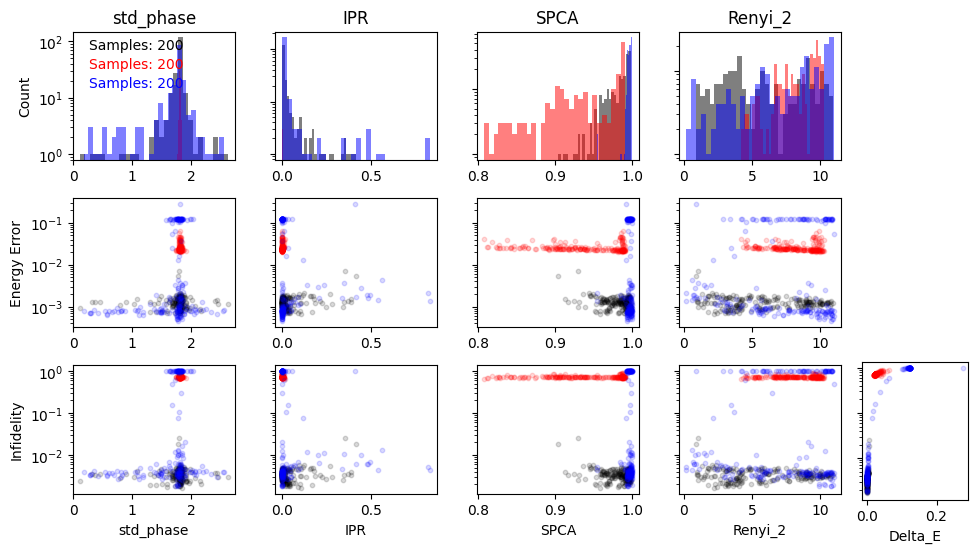

In [11]:
infidelityrange = (0,1)
df_rot_filter = df_rot[df_rot["idx"] == 10]
df_rot_filter = filter_dataframe_by_range(df_rot_filter, 'infidelity', *infidelityrange)
plt_fig = plotCorrelations(df_rot_filter,hypotheses,alphamod=0.5,ylog=True)

df_rot_filter = df_rot[df_rot["idx"] == 30]
df_rot_filter = filter_dataframe_by_range(df_rot_filter, 'infidelity', *infidelityrange)
plt_fig = plotCorrelations(df_rot_filter,hypotheses,color="red",plt_fig=plt_fig,alphamod=0.5,ylog=True)

df_rot_filter = df_rot[df_rot["idx"] == 50]
df_rot_filter = filter_dataframe_by_range(df_rot_filter, 'infidelity', *infidelityrange)
plt_fig = plotCorrelations(df_rot_filter,hypotheses,color="blue",plt_fig=plt_fig,text_offset=[0.0,-0.3],alphamod=0.5,ylog=True)

In [12]:
def plotRots(J_check, h_check, J_min, h_min, max_inf_idx, min_inf_idx, df_rot_filter):
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))

# Jij[50] before rotation
    im0 = axes[0, 0].imshow(J_check, cmap='bwr')
    axes[0, 0].set_title("J_1 worst: I = {:.3f}".format(df_rot_filter.loc[max_inf_idx, "infidelity"]))
    plt.colorbar(im0, ax=axes[0, 0], fraction=0.046, pad=0.04)

# abs(Jij[50]) before rotation
    im0_abs = axes[1, 0].imshow(np.abs(J_check), cmap='viridis')
    axes[1, 0].set_title("abs( J_1 worst: I = {:.3f}".format(df_rot_filter.loc[max_inf_idx, "infidelity"]))
    plt.colorbar(im0_abs, ax=axes[1, 0], fraction=0.046, pad=0.04)

# Jij[50] after optimal rotation
    im1 = axes[0, 1].imshow(J_min, cmap='bwr')
    axes[0, 1].set_title("J_1 best: I = {:.3f}".format(df_rot_filter.loc[min_inf_idx, "infidelity"]))
    plt.colorbar(im1, ax=axes[0, 1], fraction=0.046, pad=0.04)

# abs(Jij[50]) after optimal rotation
    im1_abs = axes[1, 1].imshow(np.abs(J_min), cmap='viridis')
    axes[1, 1].set_title("abs(J_1 best: I = {:.3f}".format(df_rot_filter.loc[min_inf_idx, "infidelity"]))
    plt.colorbar(im1_abs, ax=axes[1, 1], fraction=0.046, pad=0.04)

# h[50] before rotation
    axes[0, 2].bar(range(len(h_check)), h_check, color='C0')
    axes[0, 2].set_title("h worst: I = {:.3f}".format(df_rot_filter.loc[max_inf_idx, "infidelity"]))

# h[50] after optimal rotation
    axes[1, 2].bar(range(len(h_min)), h_min, color='C1')
    axes[1, 2].set_title("h best: I = {:.3f}".format(df_rot_filter.loc[min_inf_idx, "infidelity"]))

# Annotate matrix entries with color based on mean
    mean_J_check = np.mean(J_check)
    mean_J_min = np.mean(J_min)

    for (i, j), val in np.ndenumerate(J_check):
        color = 'k' if val > mean_J_check else 'w'
        axes[0, 0].text(j, i, f"{val:.2f}", ha='center', va='center', color=color, fontsize=10)
    for (i, j), val in np.ndenumerate(np.abs(J_check)):
        color = 'k' if val > mean_J_check else 'w'
        axes[1, 0].text(j, i, f"{val:.2f}", ha='center', va='center', color=color, fontsize=10)
    for (i, j), val in np.ndenumerate(J_min):
        color = 'k' if val > mean_J_min else 'w'
        axes[0, 1].text(j, i, f"{val:.2f}", ha='center', va='center', color=color, fontsize=10)
    for (i, j), val in np.ndenumerate(np.abs(J_min)):
        color = 'k' if val > mean_J_min else 'w'
        axes[1, 1].text(j, i, f"{val:.2f}", ha='center', va='center', color=color, fontsize=10)

# Annotate bar entries with color based on mean

    for idx, val in enumerate(h_check):
        va = 'bottom' if val >= 0 else 'top'
        axes[0, 2].text(idx, val, f"{val:.2f}", ha='center', va=va, fontsize=10)
    for idx, val in enumerate(h_min):
        va = 'bottom' if val >= 0 else 'top'
        axes[1, 2].text(idx, val, f"{val:.2f}", ha='center', va=va, fontsize=10)

# for ax in axes[:,0:1].flat:
    for ax in axes.flat:
        if hasattr(ax, "set_xticks"):
            ax.set_xticks([0, 1, 2])
            ax.set_xticklabels(['x', 'y', 'z'])
            ax.set_yticks([0,1,2])
            ax.set_yticklabels(['x', 'y', 'z'])
        if hasattr(ax, "set_yticks") and ax.get_ylabel() == '':
            ax.set_yticks(ax.get_yticks())

    axes[0,2].set_xticks([0, 1, 2])
    axes[0,2].set_xticklabels(['x', 'y', 'z'])
    axes[1,2].set_xticks([0, 1, 2])
    axes[1,2].set_xticklabels(['x', 'y', 'z'])
    plt.tight_layout()
    plt.show()

In [13]:
def plotRots(df, indices):
    """
    Plot Jij_0, Jij_1 and hs for one or multiple dataframe indices.
    Titles include the index and infidelity (if present in the dataframe).

    Parameters:
        df (pd.DataFrame): dataframe containing columns 'Jij_0', 'Jij_1', 'hs' and optionally 'infidelity'
        indices (int or sequence): single index or iterable of indices (row labels) to plot

    Returns:
        fig, axes: matplotlib Figure and Axes array
    """
    if isinstance(indices, (int, np.integer)):
        indices = [int(indices)]
    else:
        indices = [int(i) for i in indices]

    n = len(indices)
    fig, axes = plt.subplots(n, 3, figsize=(15, 4 * n), squeeze=False)

    for r, idx in enumerate(indices):
        row_axes = axes[r]

        # read from dataframe via .loc
        J0 = df.loc[idx, "Jij_0"]
        J1 = df.loc[idx, "Jij_1"]
        h = df.loc[idx, "hs"]
        inf = df.loc[idx, "infidelity"] if "infidelity" in df.columns else None

        # Plot Jij_0
        im0 = row_axes[0].imshow(J0, cmap="bwr", aspect="equal")
        fig.colorbar(im0, ax=row_axes[0], fraction=0.046, pad=0.04)
        title0 = f"Jij_0 (idx={idx})" + (f"  inf={inf:.3g}" if inf is not None else "")
        row_axes[0].set_title(title0)

        # Annotate Jij_0
        mean0 = np.mean(J0)
        for (i, j), val in np.ndenumerate(J0):
            txt_color = "k" if val > mean0 else "w"
            row_axes[0].text(j, i, f"{val:.2f}", ha="center", va="center", color=txt_color, fontsize=9)

        # Plot Jij_1
        im1 = row_axes[1].imshow(J1, cmap="bwr", aspect="equal")
        fig.colorbar(im1, ax=row_axes[1], fraction=0.046, pad=0.04)
        title1 = f"Jij_1 (idx={idx})" + (f"  inf={inf:.3g}" if inf is not None else "")
        row_axes[1].set_title(title1)

        # Annotate Jij_1
        mean1 = np.mean(J1)
        for (i, j), val in np.ndenumerate(J1):
            txt_color = "k" if val > mean1 else "w"
            row_axes[1].text(j, i, f"{val:.2f}", ha="center", va="center", color=txt_color, fontsize=9)

        # Plot h
        row_axes[2].bar(range(len(h)), h, color="C1")
        title2 = f"h (idx={idx})" + (f"  inf={inf:.3g}" if inf is not None else "")
        row_axes[2].set_title(title2)
        row_axes[2].set_xticks(list(range(len(h))))
        row_axes[2].set_xticklabels(["x", "y", "z"][: len(h)])

        for i_val, val in enumerate(h):
            va = "bottom" if val >= 0 else "top"
            row_axes[2].text(i_val, val, f"{val:.2f}", ha="center", va=va, fontsize=9)

        # common ticks/labels for matrix plots (assume 3x3 coupling matrices)
        for ax in (row_axes[0], row_axes[1]):
            ax.set_xticks([0, 1, 2])
            ax.set_xticklabels(["x", "y", "z"])
            ax.set_yticks([0, 1, 2])
            ax.set_yticklabels(["x", "y", "z"])

    plt.tight_layout()
    return fig, axes

(<Figure size 1500x1600 with 20 Axes>,
 array([[<Axes: title={'center': 'Jij_0 (idx=18)  inf=1'}>,
         <Axes: title={'center': 'Jij_1 (idx=18)  inf=1'}>,
         <Axes: title={'center': 'h (idx=18)  inf=1'}>],
        [<Axes: title={'center': 'Jij_0 (idx=115)  inf=1'}>,
         <Axes: title={'center': 'Jij_1 (idx=115)  inf=1'}>,
         <Axes: title={'center': 'h (idx=115)  inf=1'}>],
        [<Axes: title={'center': 'Jij_0 (idx=318)  inf=0.00178'}>,
         <Axes: title={'center': 'Jij_1 (idx=318)  inf=0.00178'}>,
         <Axes: title={'center': 'h (idx=318)  inf=0.00178'}>],
        [<Axes: title={'center': 'Jij_0 (idx=196)  inf=0.00261'}>,
         <Axes: title={'center': 'Jij_1 (idx=196)  inf=0.00261'}>,
         <Axes: title={'center': 'h (idx=196)  inf=0.00261'}>]],
       dtype=object))

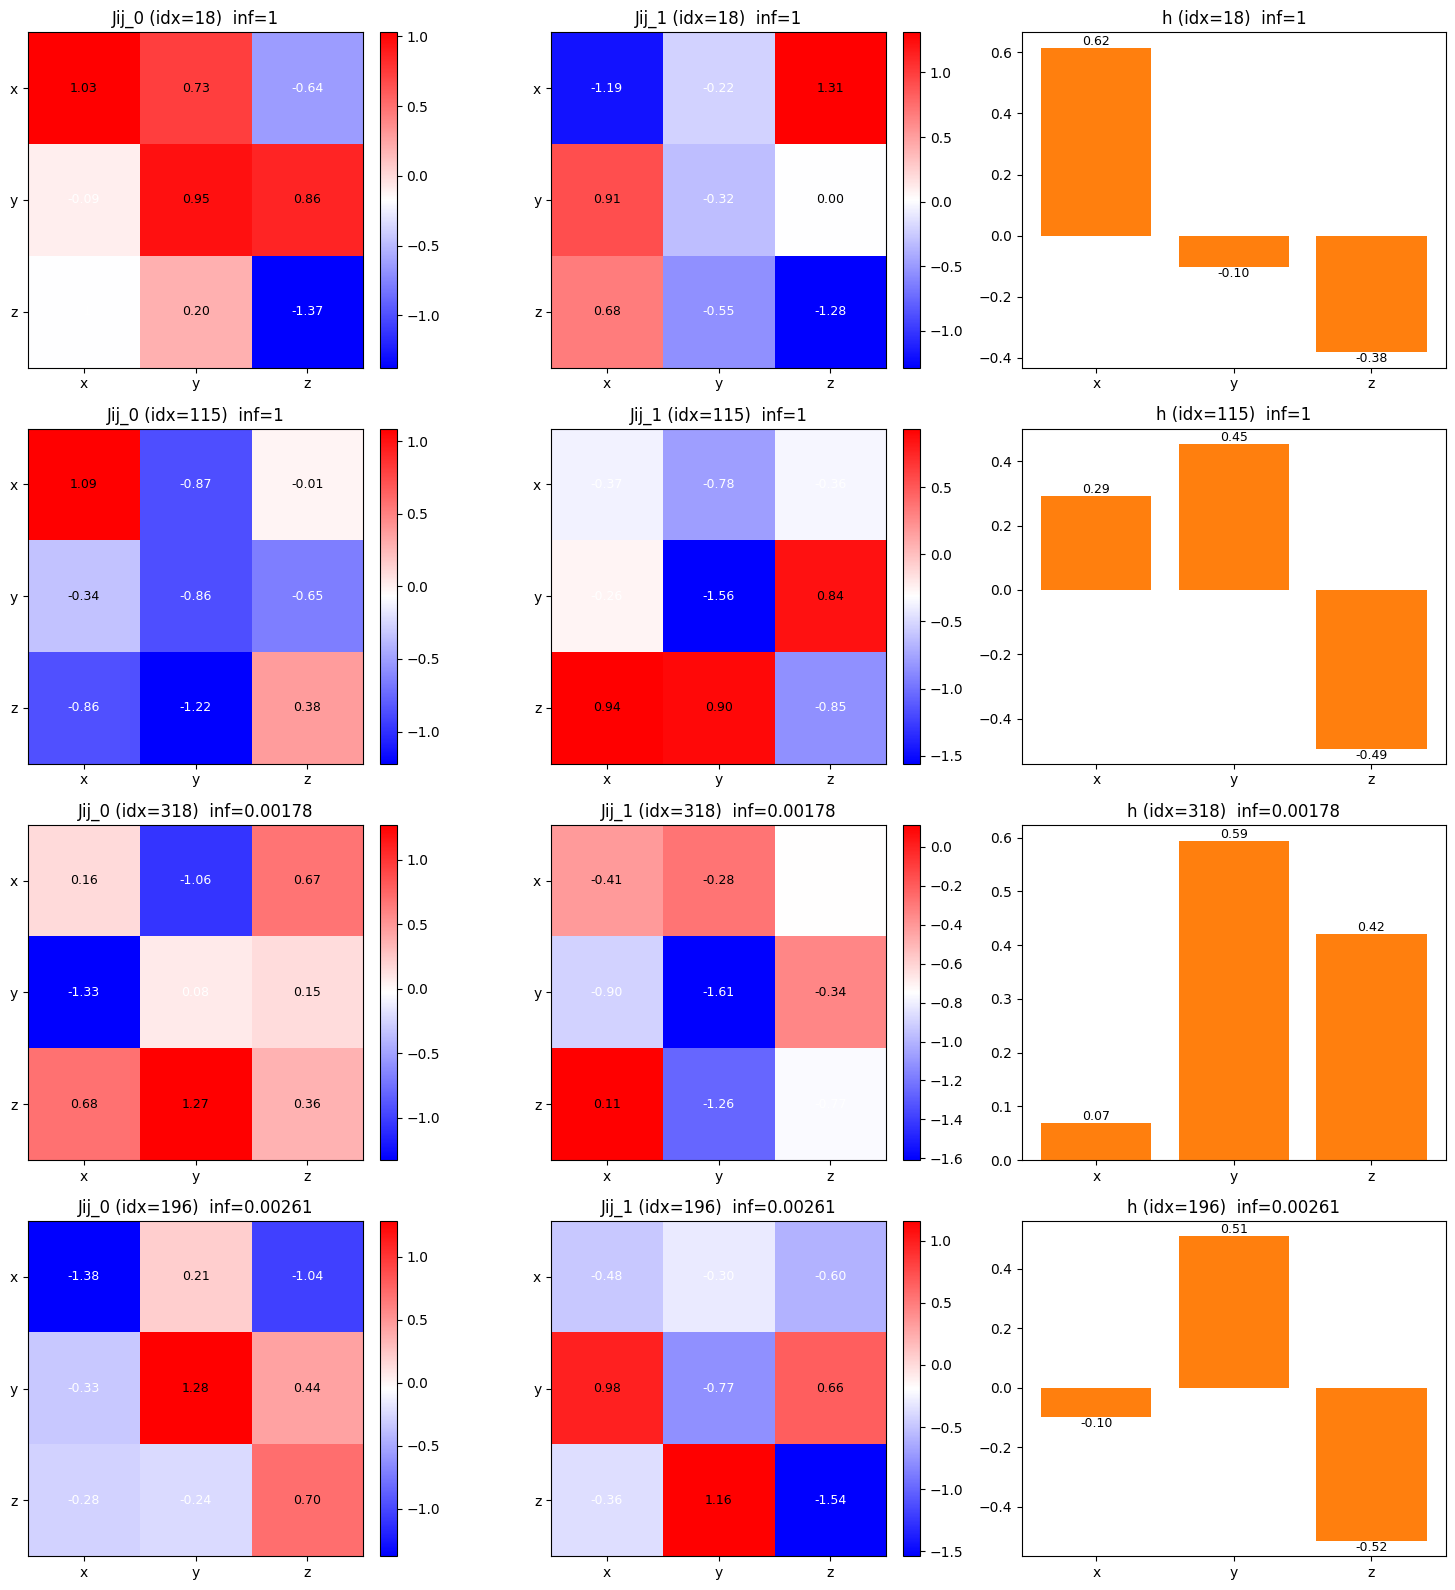

In [14]:
s = df_rot_filter["infidelity"]
i1 = s.nlargest(10).index[0]
i2 = s.nlargest(10).index[9]
i3 = s.nsmallest(10).index[0]
i4 = s.nsmallest(10).index[9]
plotRots(df_rot_filter, [i1, i2, i3, i4])


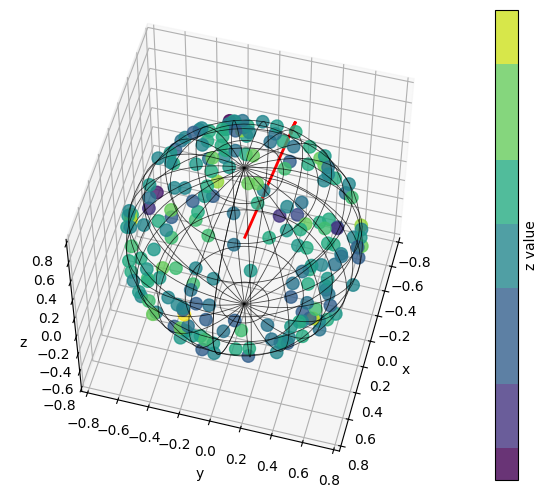

In [34]:
df_rot_filter = df_rot[df_rot["idx"] == 50]
df_rot_filter = filter_dataframe_by_range(df_rot_filter, 'infidelity', *infidelityrange)

import numpy as np
import matplotlib.pyplot as plt
# plt.switch_backend('qt5agg')
from mpl_toolkits.mplot3d import Axes3D  # required in some environments

# example points: list-of-lists or numpy array
points = df_rot_filter.hs.values

# unpack columns
x = [p[0] for p in points]
y = [p[1] for p in points]
z = [p[2] for p in points]


fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111, projection='3d')
# draw a sphere (scaled to cover the points) as a wireframe + faint surface
X_arr = np.array(x)
Y_arr = np.array(y)
Z_arr = np.array(z)
r_pts = np.max(np.sqrt(X_arr**2 + Y_arr**2 + Z_arr**2))
if r_pts == 0:
    r_pts = 1.0

u = np.linspace(0, 2 * np.pi, 60)
v = np.linspace(0, np.pi, 30)
U, V = np.meshgrid(u, v)
Xs = r_pts * np.cos(U) * np.sin(V)
Ys = r_pts * np.sin(U) * np.sin(V)
Zs = r_pts * np.cos(V)

# wireframe + faint surface
ax.plot_wireframe(Xs, Ys, Zs, color="black", linewidth=0.6, rstride=3, cstride=3, alpha=0.7)
# ax.plot_surface(Xs, Ys, Zs, color="lightgray", alpha=0.12, linewidth=0, antialiased=True)

major_direction = sum([points[i]*np.array(df_rot_filter.infidelity)[i] for i in range(len(df_rot_filter))])
major_direction = -major_direction / np.linalg.norm(major_direction) * (r_pts*1.2)
# plot major direction
ax.quiver(0, 0, 0, major_direction[0], major_direction[1], major_direction[2], color='red', linewidth=2, arrow_length_ratio=0.1, label='Infidelity-weighted direction')
# keep aspect ratio equal
try:
    ax.set_box_aspect([1, 1, 1])
except Exception:
    pass
# sc = ax.scatter(x, y, z, c=df_rot_filter.infidelity, cmap='viridis', s=80, alpha=0.8)

J_means = [J_0+J_1 for (J_0, J_1) in zip(df_rot_filter.Jij_0.values, df_rot_filter.Jij_1.values)]
# infidelity_ansatz = [J[2,2] for J in df_rot_filter.Jij_0.values]
# infidelity_ansatz = [J_0[2,2]+J_1[2,2] for (J_0, J_1) in zip(df_rot_filter.Jij_0.values, df_rot_filter.Jij_1.values)]
infidelity_ansatz = [(h@J_0@h) for (J_0, h) in zip(J_means, df_rot_filter.hs.values)]
sc = ax.scatter(x, y, z, c=infidelity_ansatz, cmap='viridis', s=80, alpha=0.8)
# set static view angles (change values as desired)
azim = 15  # azimuth angle in degrees
elev = 55  # elevation angle in degrees
ax.view_init(elev=elev, azim=azim)

# optional: animate rotation (uncomment to run)
# for az in range(0, 360, 4):
#     el = 25 * np.sin(np.deg2rad(az / 2))  # varying elevation if desired
#     ax.view_init(elev=el, azim=az)
#     plt.draw()
#     plt.pause(0.01)
ax.set_xlabel('x'); ax.set_ylabel('y'); ax.set_zlabel('z')
plt.colorbar(sc, label='z value')
plt.tight_layout()
plt.show()

[np.float64(-0.8519998699771089),
 np.float64(0.7337512966973325),
 np.float64(0.20051736206349802),
 np.float64(0.8834792794594378),
 np.float64(-0.9777092661736527),
 np.float64(0.2368191716893577),
 np.float64(0.8879935396390368),
 np.float64(-0.3522266600202646),
 np.float64(-0.7092119120984718),
 np.float64(0.39269669907217775),
 np.float64(0.9417619391450066),
 np.float64(-0.981610691246741),
 np.float64(0.7163660037590569),
 np.float64(-0.035094516563237144),
 np.float64(-0.126782343810666),
 np.float64(-0.06562428067685616),
 np.float64(0.7417592530533084),
 np.float64(-0.14100331417522308),
 np.float64(0.06841762751865367),
 np.float64(-0.872285547266219),
 np.float64(0.06337118886614884),
 np.float64(-0.5523524813806859),
 np.float64(-0.5260982956327903),
 np.float64(0.7622706589874592),
 np.float64(0.31157564086993006),
 np.float64(-0.9865780571337568),
 np.float64(-0.7314016190493116),
 np.float64(0.933332925897602),
 np.float64(0.42396757930501144),
 np.float64(0.328955290

In [16]:
# max_inf_idx = df_rot_filter["infidelity"].idxmax()
# min_inf_idx = df_rot_filter["infidelity"].idxmin()
s = df_rot_filter["infidelity"]
max_inf_idx = s.nlargest(2).index[1]
min_inf_idx = s.nsmallest(2).index[1]

J_check = df_rot_filter.loc[max_inf_idx, "Jij_0"]
h_check = df_rot_filter.loc[max_inf_idx, "hs"]

J_min = df_rot_filter.loc[min_inf_idx, "Jij_0"]
h_min = df_rot_filter.loc[min_inf_idx, "hs"]

# max_inf_idx = s.nlargest(2).index[1]
# min_inf_idx = s.nsmallest(2).index[1]

plotRots(J_check, h_check, J_min, h_min, max_inf_idx, min_inf_idx, df_rot_filter)

J_check = df_rot_filter.loc[max_inf_idx, "Jij_1"]
h_check = df_rot_filter.loc[max_inf_idx, "hs"]

J_min = df_rot_filter.loc[min_inf_idx, "Jij_1"]
h_min = df_rot_filter.loc[min_inf_idx, "hs"]

plotRots(J_check, h_check, J_min, h_min, max_inf_idx, min_inf_idx, df_rot_filter)

TypeError: plotRots() takes 2 positional arguments but 7 were given

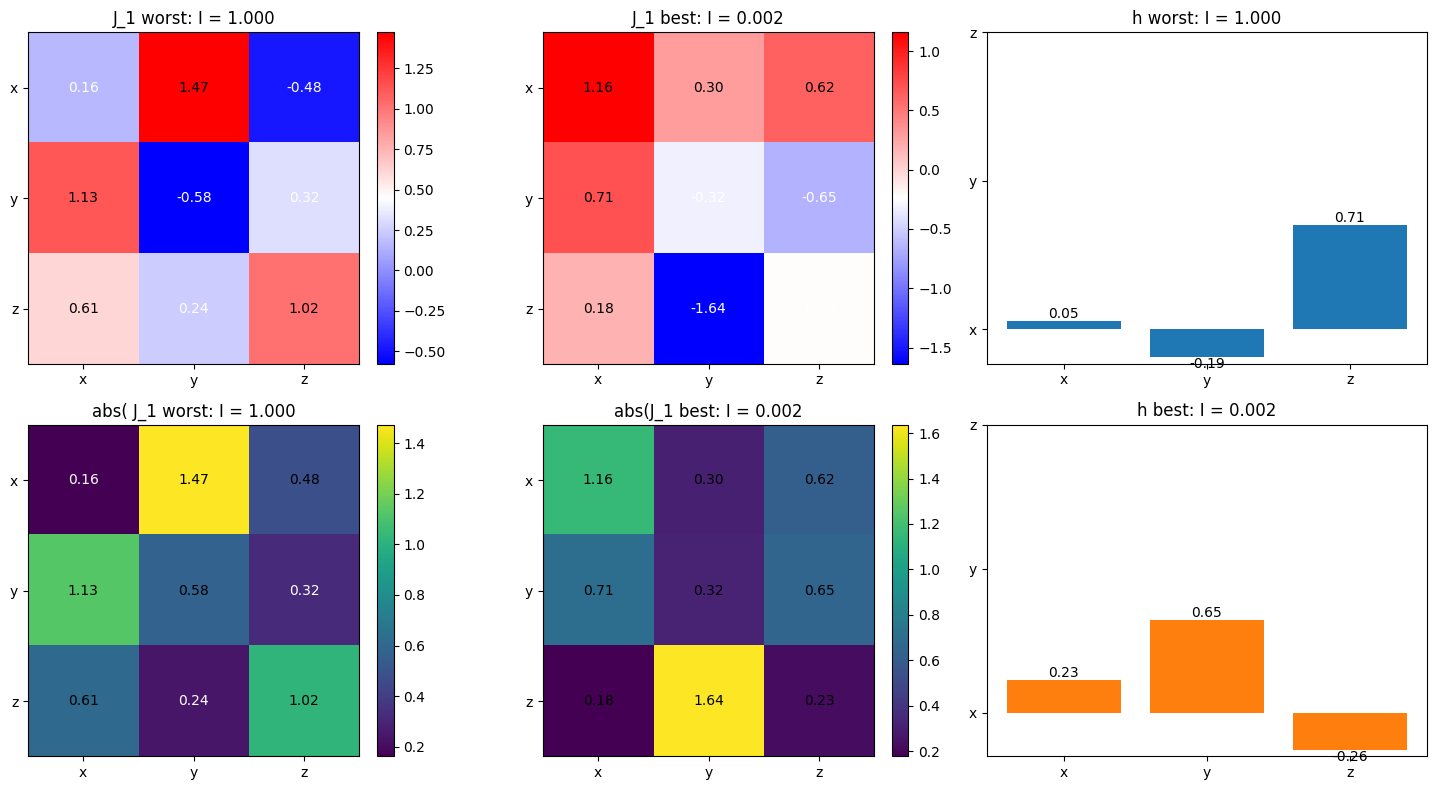

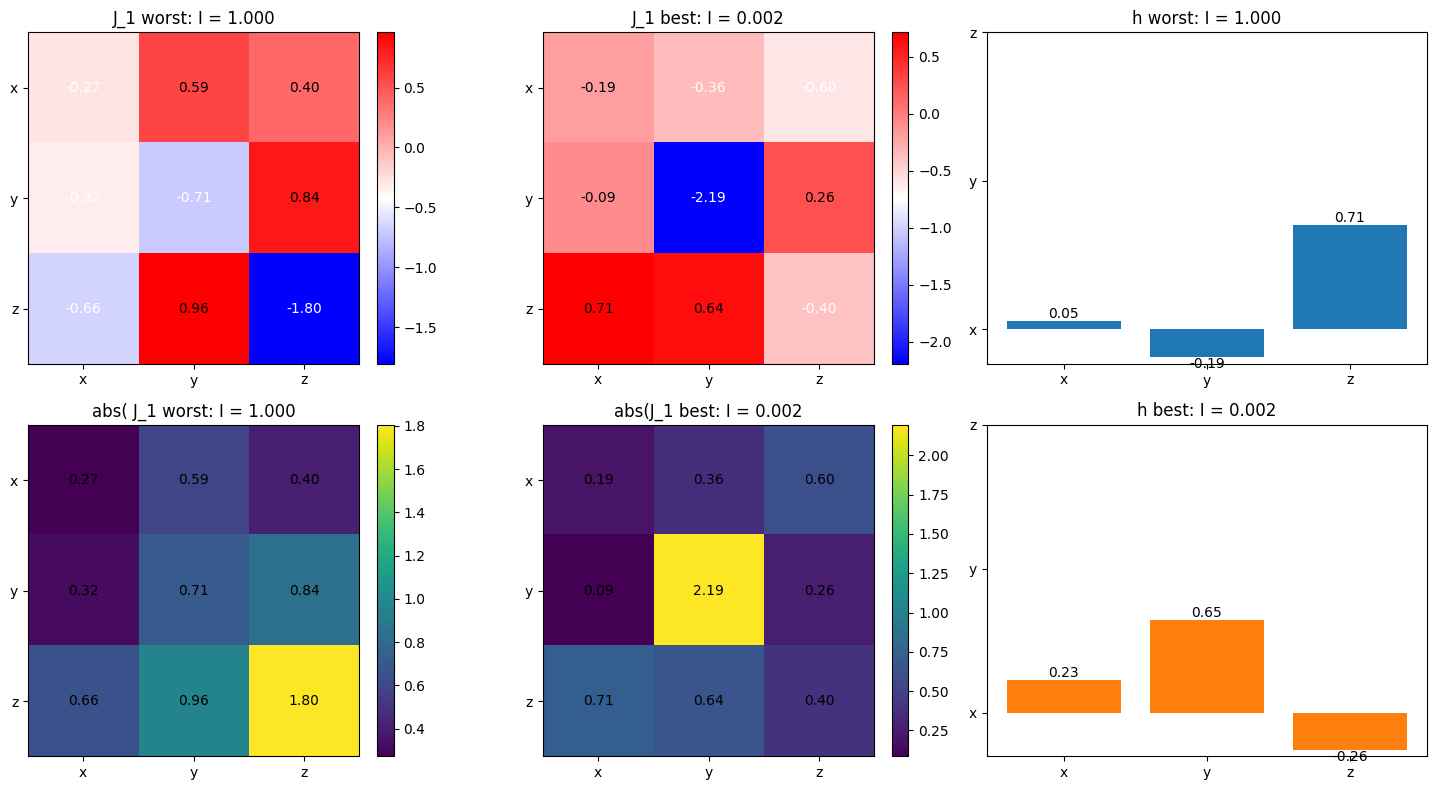

In [ ]:
# max_inf_idx = df_rot_filter["infidelity"].idxmax()
# min_inf_idx = df_rot_filter["infidelity"].idxmin()
s = df_rot_filter["infidelity"]
max_inf_idx = s.nlargest(3).index[1]
min_inf_idx = s.nsmallest(3).index[1]

J_check = df_rot_filter.loc[max_inf_idx, "Jij_0"]
h_check = df_rot_filter.loc[max_inf_idx, "hs"]

J_min = df_rot_filter.loc[min_inf_idx, "Jij_0"]
h_min = df_rot_filter.loc[min_inf_idx, "hs"]

# max_inf_idx = s.nlargest(2).index[1]
# min_inf_idx = s.nsmallest(2).index[1]

plotRots(J_check, h_check, J_min, h_min, max_inf_idx, min_inf_idx, df_rot_filter)

J_check = df_rot_filter.loc[max_inf_idx, "Jij_1"]
h_check = df_rot_filter.loc[max_inf_idx, "hs"]

J_min = df_rot_filter.loc[min_inf_idx, "Jij_1"]
h_min = df_rot_filter.loc[min_inf_idx, "hs"]

plotRots(J_check, h_check, J_min, h_min, max_inf_idx, min_inf_idx, df_rot_filter)

In [ ]:
hypotheses = {
    "std_phase" : std_phase,
    "IPR" : ipr,
    "SPCA" : pca_entropy,
    "Renyi_2" : renyi_entropy,
}
df_rot = analysis.load_outputs_to_dataframe(h5_files)
df_rot = analysis.attach_hypotheses_fields(df_rot, hypotheses)
df_rot["rot_alpha"] = np.array([analysis.read_h5_attributes(f)["rot_alpha"] for f in h5_files])
df_rot["rot_beta"] = np.array([analysis.read_h5_attributes(f)["rot_beta"] for f in h5_files])
df_rot["rot_gamma"] = np.array([analysis.read_h5_attributes(f)["rot_gamma"] for f in h5_files])

KeyError: 'rot_alpha'